In [1]:
import torch
import json
import os
import numpy as np
import torch.nn.functional as F
from importlib.machinery import SourceFileLoader
from matplotlib import pyplot as plt

from pado.light import * 
from pado.optical_element import *
from pado.propagator import *

from utils.utils import *

In [2]:
import skimage

def get_pitch(param):
    return param.DOE_pitch if hasattr(param, "DOE_pitch") else param.meta_pitch

def get_image_sample_ratio(param):
    return param.image_sample_ratio if hasattr(param, "image_sample_ratio") else 1.0

def visualize(tensor, cmap='hsv', vmin=None, vmax=None, figsize=None, axis=True, title=None, psnr=None, ssim=None, l1=None):
    plt.figure(figsize=figsize)
    if (vmin is not None) and (vmax is not None):
        plt.imshow(tensor[0].permute(1,2,0).cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.imshow(tensor[0].permute(1,2,0).cpu().detach().numpy(), cmap=cmap)
    if axis:
        plt.colorbar()
    else:
        plt.axis('off')
    title_string = title if title is not None else '' 
    title_string += f' l1: {l1:.3f}' if l1 is not None else ''
    title_string += f' psnr: {psnr:.3f}' if psnr is not None else ''
    title_string += f' ssim: {ssim:.3f}' if ssim is not None else ''
    plt.title(title_string)
    plt.show()

def visualize_images_grid(images, nrows=10, ncols=10, cmap="gray", figsize=(12, 12)):
    """
    리스트 안에 있는 이미지들을 nrows x ncols grid로 시각화하는 함수.
    200개 데이터를 100개씩 두 장으로 나눠 그림.
    """
    num_images = len(images)
    total_slots = nrows * ncols
    num_pages = int(np.ceil(num_images / total_slots))

    for page in range(num_pages):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        start_idx = page * total_slots
        end_idx = min((page + 1) * total_slots, num_images)

        for idx, ax in enumerate(axes):
            global_idx = start_idx + idx
            if global_idx < end_idx:
                img = images[global_idx]
                img = img.cpu().detach().numpy() if hasattr(img, "cpu") else np.asarray(img)
                ax.imshow(img, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                # 빈칸: 축만 남김
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(True)

        plt.tight_layout()
        plt.show()

def plot_psf_2d_grid(psf_list, wl_list, pitch, nrows=5, ncols=5, cmap="hot", figsize=(12, 12), normalize=True):
    """
    2D PSF grid with physical axes (μm).
    """
    num_images = len(psf_list)
    total_slots = nrows * ncols
    num_pages = int(np.ceil(num_images / total_slots))

    for page in range(num_pages):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()
        start_idx = page * total_slots
        end_idx = min((page + 1) * total_slots, num_images)

        for idx, ax in enumerate(axes):
            global_idx = start_idx + idx
            if global_idx < end_idx:
                psf = psf_list[global_idx]
                wl = wl_list[global_idx]
                d2 = psf.cpu().detach().numpy() if hasattr(psf, "cpu") else np.asarray(psf)
                if normalize:
                    d2 = d2 / (d2.max() + 1e-12)
                h, w = d2.shape
                extent = [-w//2 * pitch * 1e6, w//2 * pitch * 1e6, -h//2 * pitch * 1e6, h//2 * pitch * 1e6]
                ax.imshow(d2, cmap=cmap, extent=extent, origin="lower")
                ax.set_title(f"{int(wl*1e9)} nm", fontsize=8)
                ax.set_xlabel("x (μm)", fontsize=7)
                ax.set_ylabel("y (μm)", fontsize=7)
                ax.tick_params(axis='both', labelsize=6)
            else:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(True)
                ax.set_title("")

        plt.tight_layout()
        plt.show()

import numpy as np
from scipy.ndimage import center_of_mass

def radial_mean_2d(psf_2d):
    """
    Radial mean of a 2D PSF over the full circle.
    Returns 1D profile where index corresponds to radius in pixels.
    """
    img = psf_2d.cpu().detach().numpy() if hasattr(psf_2d, "cpu") else np.asarray(psf_2d)
    h, w = img.shape
    cy = (h - 1) / 2.0
    cx = (w - 1) / 2.0
    y, x = np.indices((h, w))
    r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    r_int = r.astype(np.int32).ravel()

    vals = img.ravel()
    r_max = r_int.max()

    sums = np.bincount(r_int, weights=vals, minlength=r_max + 1).astype(np.float64)
    counts = np.bincount(r_int, minlength=r_max + 1).astype(np.float64)
    counts[counts == 0] = 1.0

    radial_mean = sums / counts

    return radial_mean

def _make_symmetric_profile(y):
    y = np.asarray(y)
    if y.shape[0] <= 1:
        return y
    return np.concatenate([y[:0:-1], y], axis=0)

def plot_psf_1d_grid(psf_list, wl_list, pitch, nrows=5, ncols=5, figsize=(15, 15), x_mode="radial"):
    """
    1D PSF grid visualization (radial or line).
    x_mode: "radial" or "line"
    """
    total_slots = nrows * ncols
    num_pages = int(np.ceil(len(psf_list) / total_slots))
    
    for page in range(num_pages):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()
        
        start_idx = page * total_slots
        end_idx = min((page + 1) * total_slots, len(psf_list))
        
        for idx, ax in enumerate(axes):
            global_idx = start_idx + idx
            if global_idx < end_idx:
                psf = psf_list[global_idx]
                wl = wl_list[global_idx]
                d1 = psf.cpu().detach().numpy() if hasattr(psf, "cpu") else np.asarray(psf)
                if x_mode == "radial":
                    y = d1 / (d1.max() + 1e-12)
                    y_sym = _make_symmetric_profile(y)
                    r_max = d1.shape[0] - 1
                    x = np.arange(-r_max, r_max + 1) * pitch * 1e6
                    ax.plot(x, y_sym, color="blue", lw=1.0)
                else:
                    x = (np.arange(d1.shape[0]) - d1.shape[0]//2) * pitch * 1e6
                    y = d1 / (d1.max() + 1e-12)
                    ax.plot(x, y, color="blue", lw=1.0)
                
                ax.set_title(f"{int(wl*1e9)} nm", fontsize=8)
                ax.set_xlabel("μm", fontsize=7)
                ax.set_ylabel("Norm. Intensity", fontsize=7)
                ax.tick_params(axis='both', labelsize=6)
            else:
                # 빈칸: 축/프레임만 남김
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(True)
                ax.set_title("")

        plt.tight_layout()
        plt.show()

def grayscale(np_img):
    return (np_img[:,:,0]+np_img[:,:,1]+np_img[:,:,2])/3

def compute_psnr(GT, image):
    psnr = skimage.metrics.peak_signal_noise_ratio(
        GT[0].permute(1, 2, 0).cpu().detach().numpy(), image[0].permute(1, 2, 0).cpu().detach().numpy())
    return psnr

def compute_ssim(GT, image):
    ssim = skimage.metrics.structural_similarity(
        GT[0].mean(axis=0).cpu().detach().numpy(), image[0].mean(axis=0).cpu().detach().numpy())
    return ssim

def compute_psf(wvl, light, args, propagator, offset=(0, 0), normalize=True, resize=True):
    '''simulate depth based psf.
    Args:
        depth: propagation distance
        propagator: propagator defined in pado library. Fresenl, Fraunhofer, Rayleigh-Sommerfeld (RS), ASM, or BL_ASM
        use_lens: If True, DOE is placed in front of the lens.
        offset: (offset_y, offset_x) tuple. metric is meter. coordinate system follows matrix indexing ((0,0) is the top left corner.)
        theta: incident angle (theta_y, theta_x) of the point light source
        pad: If True, pad or unpad the psf size to be same as image size
        full_psf: If True, build full PSF which is impossible during training

    Note that Fresenl propagation with propagation distance focal length light after refractive lens is
        equal to the Fraunhofer propagation with propagation distance focal length.
    '''
    param = args.param
    prop = Propagator(propagator)
    dim = (1,1,param.R, param.C)
    pitch = get_pitch(param)

    aperture = Aperture(dim, pitch, param.aperture_diamter, param.aperture_shape, wvl, args.device)
    light = aperture.forward(light.clone())

    light_prop = prop.forward(light, param.sensor_dist, offset=offset, linear=True)
    psf = light_prop.get_intensity()

    # resize 
    if resize:
        image_sample_ratio = get_image_sample_ratio(param)
        psf = F.interpolate(psf, scale_factor=light_prop.pitch/(param.camera_pitch* image_sample_ratio), 
                            mode=args.resizing_method)
    if normalize:
        psf = psf / torch.sum(psf)

    return psf

import tqdm
from pado.material import Material

def compute_psf_zscan(args, complex_field, depths, incident_z, wvl, crop_half=30, normalizer=None):
    bl_asm = Propagator('SBL_ASM')
    pitch = get_pitch(args.param)
    aperture = Aperture(complex_field.shape, pitch, pitch*complex_field.shape[-1], 'circle', wvl, args.device)

    xz_list = []
    radial_list = []

    for idx, depth in tqdm.tqdm(enumerate(depths)):
        light = Light(complex_field.shape, pitch, wvl,device=args.device)
        light.set_spherical_light(z=incident_z)
        light.set_field(complex_field*light.get_field())
        aperture.wvl = wvl
        light = aperture.forward(light.clone())
        psf = bl_asm.forward(light.clone(), depth, offset=(0,0), linear=False).get_intensity()
        psf = psf[0, 0, psf.shape[-2]//2-crop_half:psf.shape[-2]//2+crop_half, psf.shape[-1]//2-crop_half:psf.shape[-1]//2+crop_half].cpu().detach().numpy()
        psf = psf if normalizer is None else psf/normalizer
        center_y = psf.shape[0] // 2
        xz_list.append(psf[center_y, :])
        radial_list.append(radial_mean_2d(psf))

    xz = np.stack(xz_list, axis=-1)
    radial = np.stack(radial_list, axis=-1)

    if normalizer is None:
        xz = xz / (xz.max() + 1e-12)
        radial = radial / (radial.max() + 1e-12)

    x_um = (np.arange(xz.shape[0]) - xz.shape[0]//2) * pitch * 1e6
    r_um = np.arange(radial.shape[0]) * pitch * 1e6
    z_mm = depths.cpu().detach().numpy() * 1e3

    return xz, radial, x_um, r_um, z_mm

def plot_zscan_xz(xz, x_um, z_mm, wvl, incident_z):
    plt.figure(figsize=(10, 5))
    plt.imshow(xz, extent=[z_mm[0], z_mm[-1], x_um[0], x_um[-1]], interpolation='nearest', cmap='hot', aspect='auto', origin='lower')
    plt.xlabel('z (mm)')
    plt.ylabel('x (μm)')
    plt.title(f'X-Z slice | wvl: {wvl*1e+9:.0f} nm, incident z: {incident_z*1e3:.2f} mm')
    plt.tight_layout()
    plt.colorbar()
    plt.show()

def plot_zscan_radial(radial, r_um, z_mm, wvl, incident_z):
    radial_sym = np.concatenate([radial[:0:-1, :], radial], axis=0)
    r_sym = np.concatenate([-r_um[:0:-1], r_um], axis=0)
    plt.figure(figsize=(10, 5))
    plt.imshow(radial_sym, extent=[z_mm[0], z_mm[-1], r_sym[0], r_sym[-1]], interpolation='nearest', cmap='hot', aspect='auto', origin='lower')
    plt.xlabel('z (mm)')
    plt.ylabel('r (μm)')
    plt.title(f'Radial-sum Z-scan | wvl: {wvl*1e+9:.0f} nm, incident z: {incident_z*1e3:.2f} mm')
    plt.tight_layout()
    plt.colorbar()
    plt.show()

In [3]:
from scipy.io import savemat, loadmat
from lut import KeyedLUTSampler3D_HardGumbel_Complex

ckpt_path = './logs/3000_Natural_trained'
args = json.load(open(ckpt_path + '/args.json'))
args = AttributeDict(args)

args.device = 'cuda:4' 

param = SourceFileLoader("param", os.path.join(ckpt_path,args.param_file.split('/')[-1])).load_module()
args.param = param

# Choose checkpoint tag: 'min_eval' or a step like '000400'
saved_tag = 'min_eval'

layer1_indices = torch.load(os.path.join(ckpt_path, f'layer1_indices_{saved_tag}.pt'), map_location=args.device).detach()
layer2_indices = torch.load(os.path.join(ckpt_path, f'layer2_indices_{saved_tag}.pt'), map_location=args.device).detach()
class_logits = torch.load(os.path.join(ckpt_path, f'class_logits_{saved_tag}.pt'), map_location=args.device).detach()

cycy = torch.tensor(np.load(args.cycy), device=args.device).to(torch.complex64)
cysq = torch.tensor(np.load(args.cysq), device=args.device).to(torch.complex64)
sqcy = torch.tensor(np.load(args.sqcy), device=args.device).to(torch.complex64)
sqsq = torch.tensor(np.load(args.sqsq), device=args.device).to(torch.complex64)
lut_dict = {int(wvl*1e+9): torch.stack([cycy[...,wvl_idx], cysq[...,wvl_idx], sqcy[...,wvl_idx], sqsq[...,wvl_idx]], dim=0) 
            for (wvl_idx, wvl) in enumerate(param.full_broadband_wvls)}

lut_sampler_hard = KeyedLUTSampler3D_HardGumbel_Complex(lut_dict, use_hard=True, hard_eval=True).to(args.device)
lut_sampler_hard.eval()

# PSF visualization: use all wavelengths between 400-700 nm
psf_wvls = [w for w in param.full_broadband_wvls if 400e-9 <= w <= 700e-9]
print(f"PSF wavelengths: {[int(w*1e9) for w in psf_wvls]}")


PSF wavelengths: [400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 59

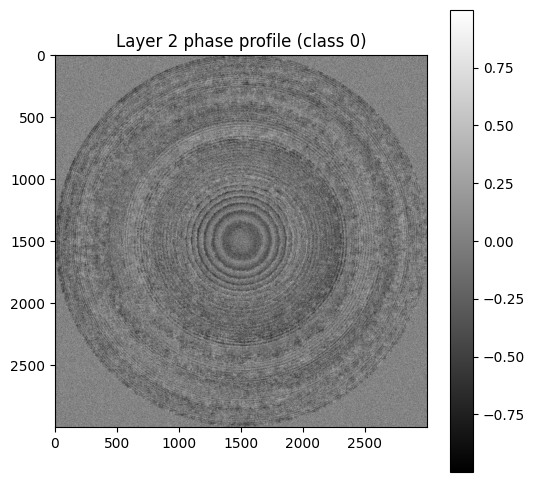

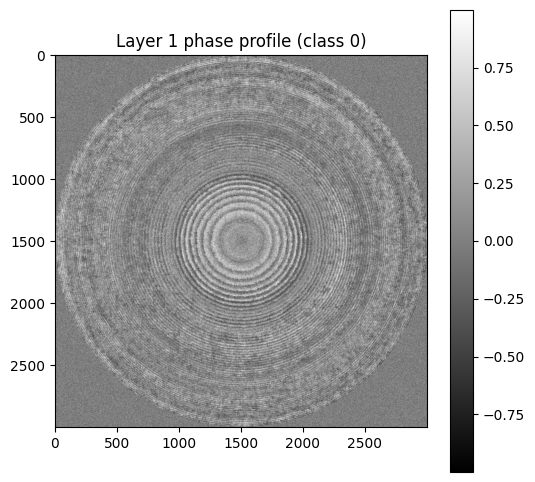

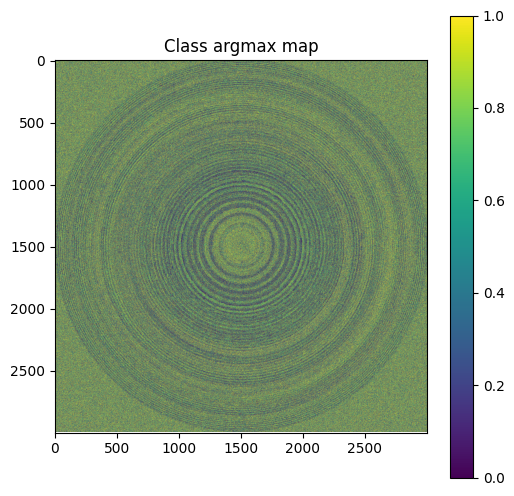

In [4]:
layer2_vis = 2.0*torch.sigmoid(layer2_indices[:,0:1,...])-1
layer1_vis = 2.0*torch.sigmoid(layer1_indices[:,0:1,...])-1
class_map = torch.argmax(class_logits, dim=1, keepdim=True).float()
if class_logits.shape[1] > 1:
    class_map = class_map / (class_logits.shape[1] - 1.0)

visualize(layer2_vis, cmap='gray', figsize=(6,6), title='Layer 2 phase profile (class 0)')
visualize(layer1_vis, cmap='gray', figsize=(6,6), title='Layer 1 phase profile (class 0)')
visualize(class_map, cmap='viridis', figsize=(6,6), title='Class argmax map')

# PSF at high resolution (Verificiation, nearest neighbor sampled)

# Radially sum 2D PSF to get 1D PSF

In [5]:
# np.save('channel_index.npy', index_output_dict[620]['channel_index'].squeeze().cpu().numpy())
# np.save('h_index.npy', index_output_dict[620]['h_index'].squeeze().cpu().numpy())
# np.save('w_index.npy', index_output_dict[620]['w_index'].squeeze().cpu().numpy())

100%|██████████| 141/141 [00:08<00:00, 16.40it/s]


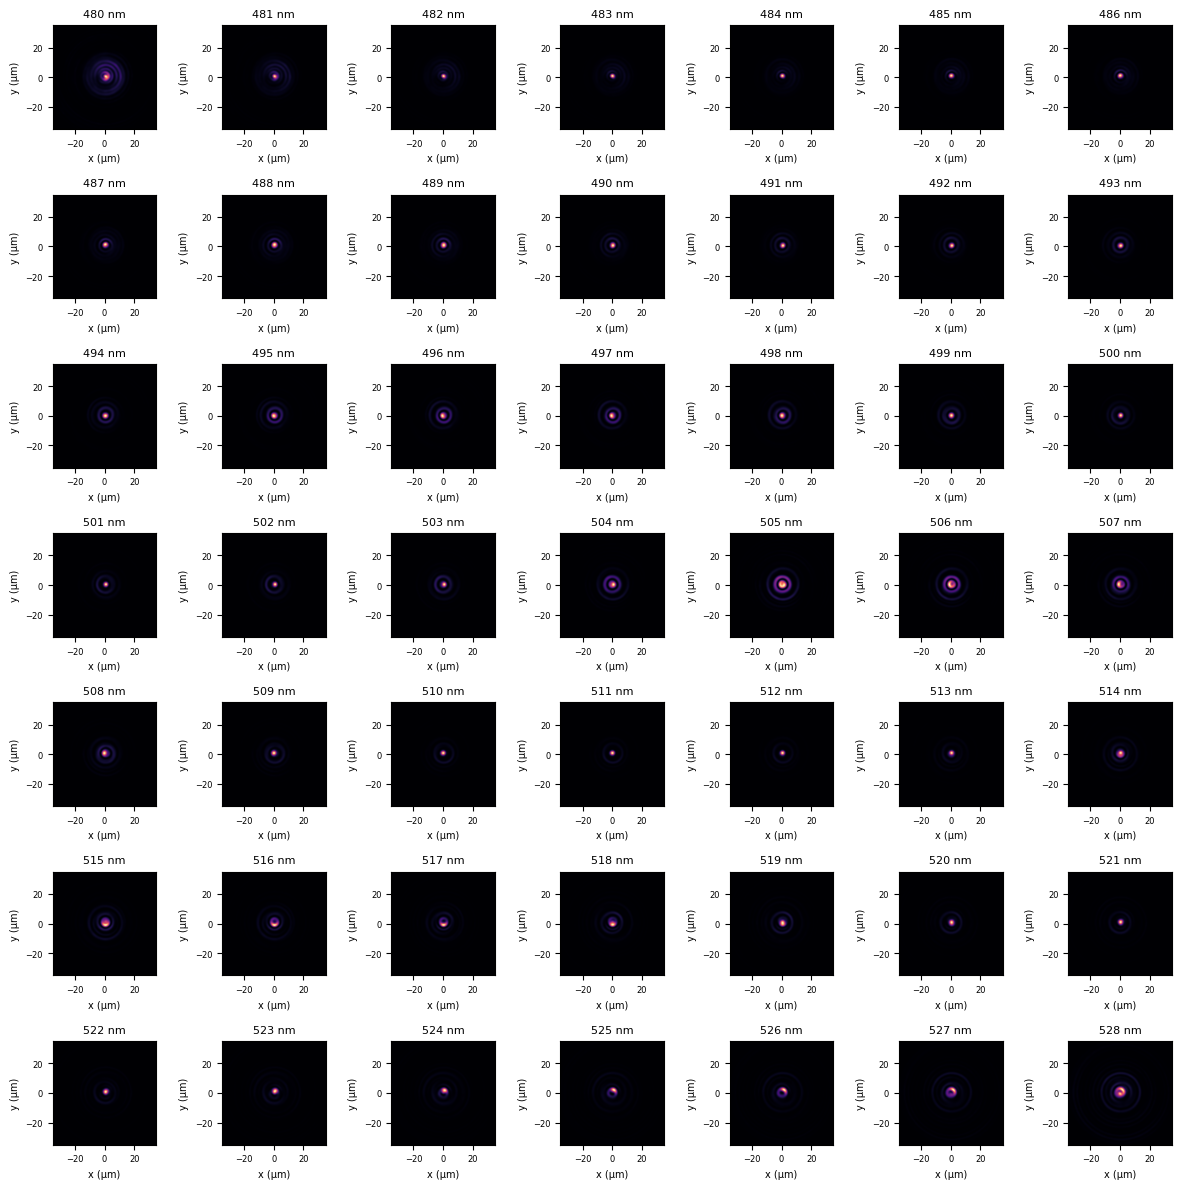

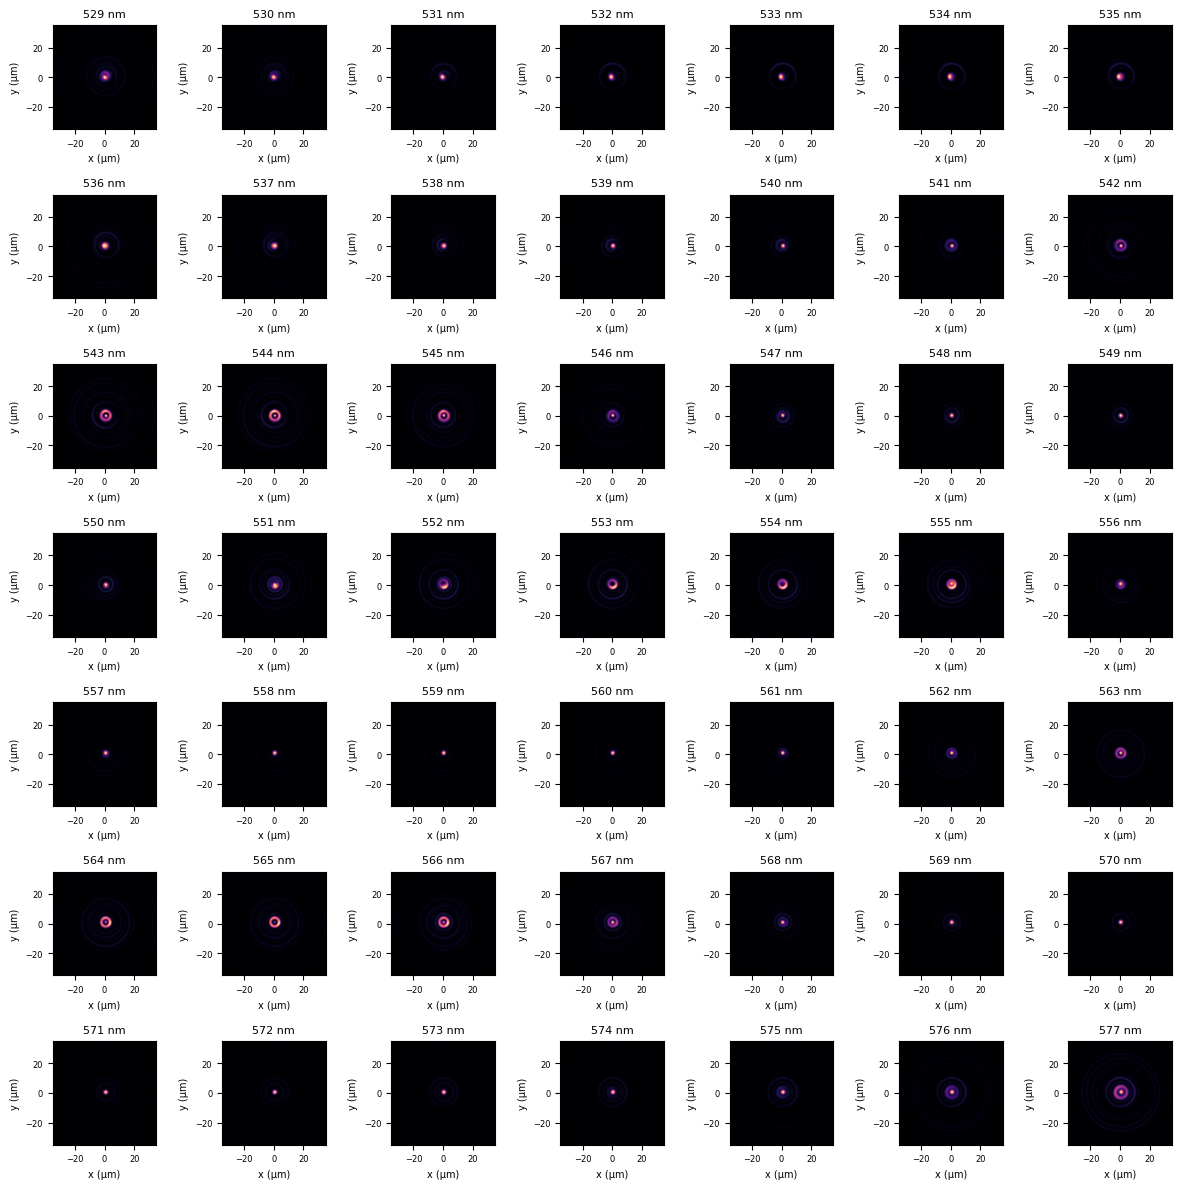

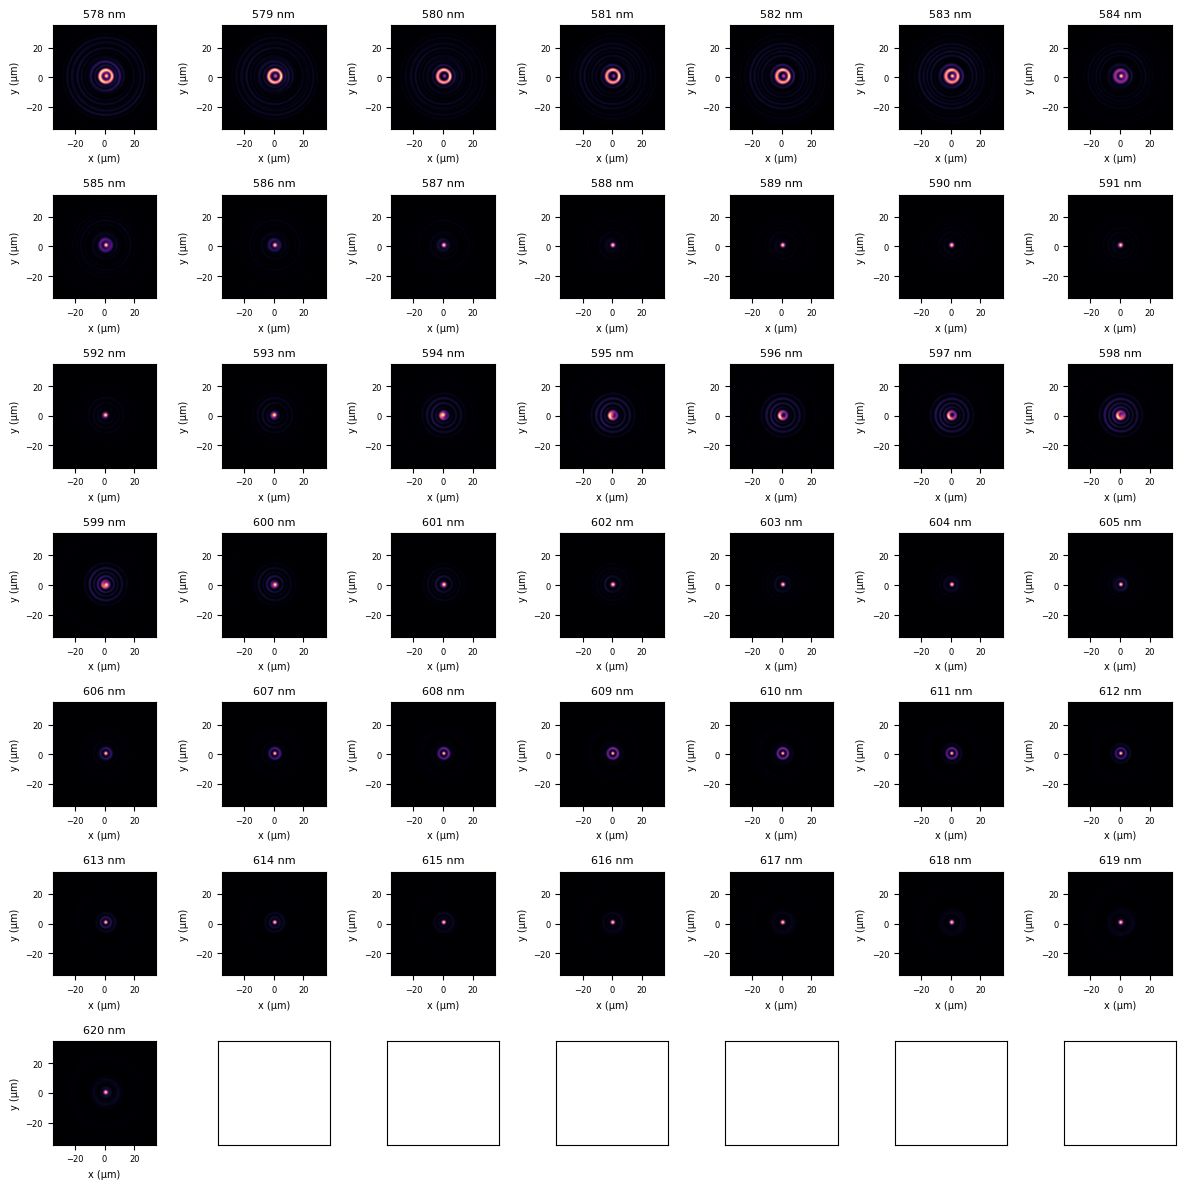

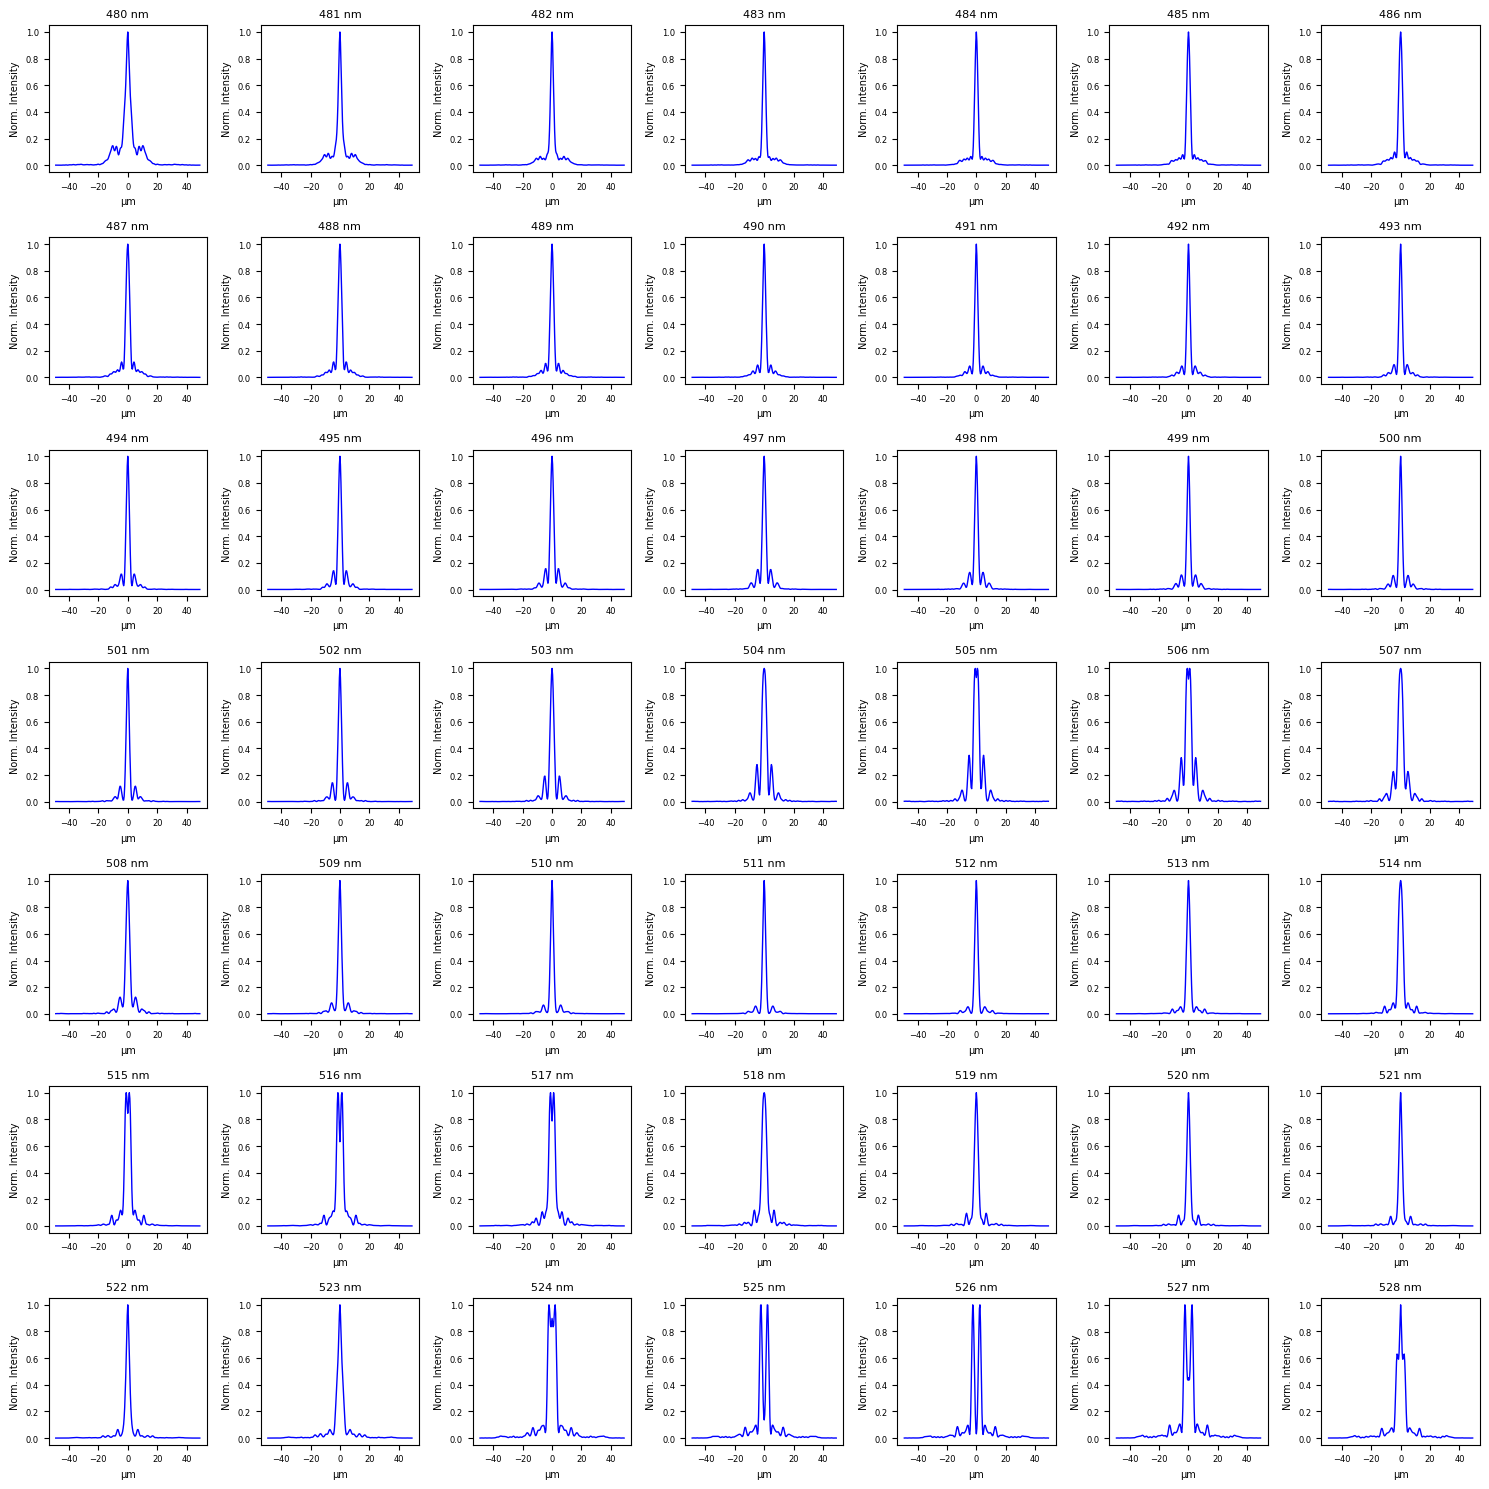

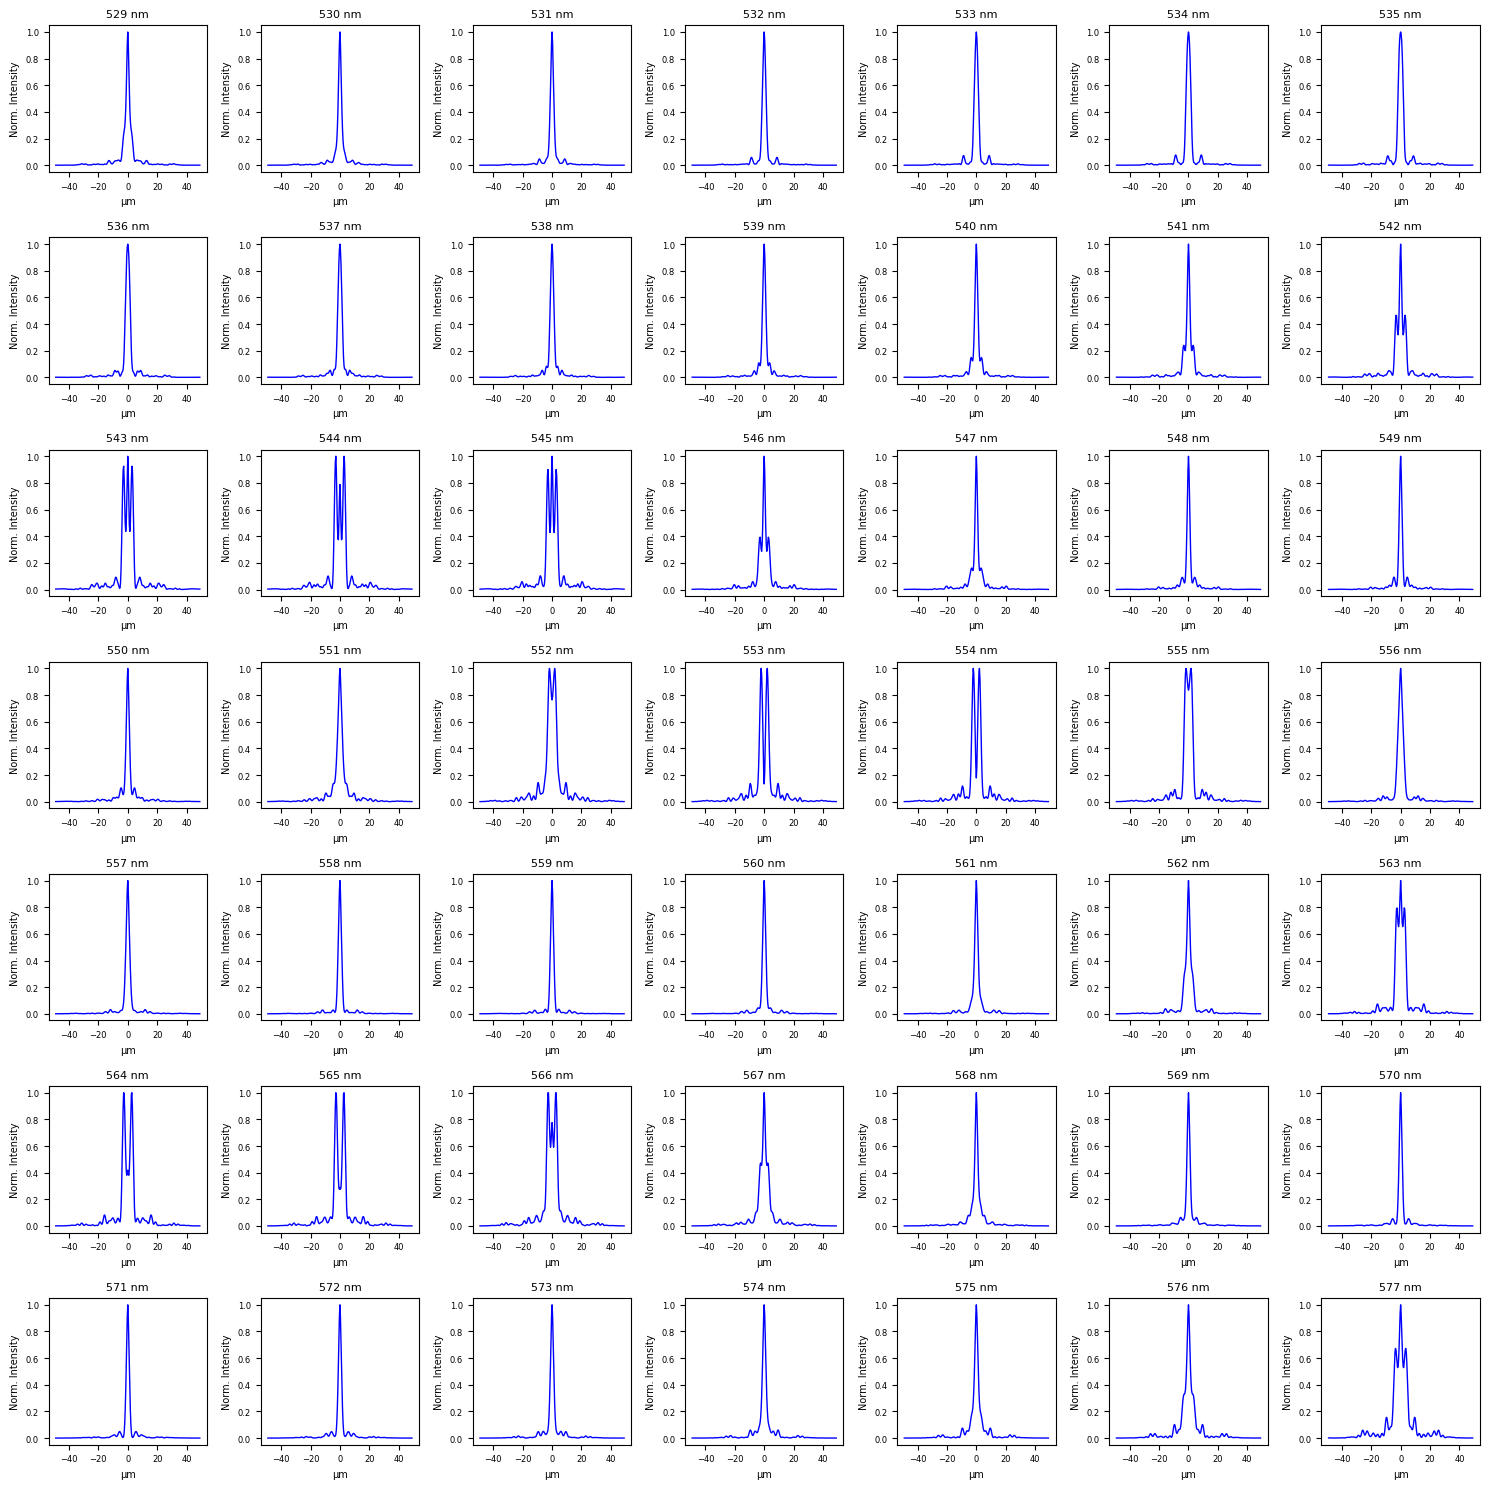

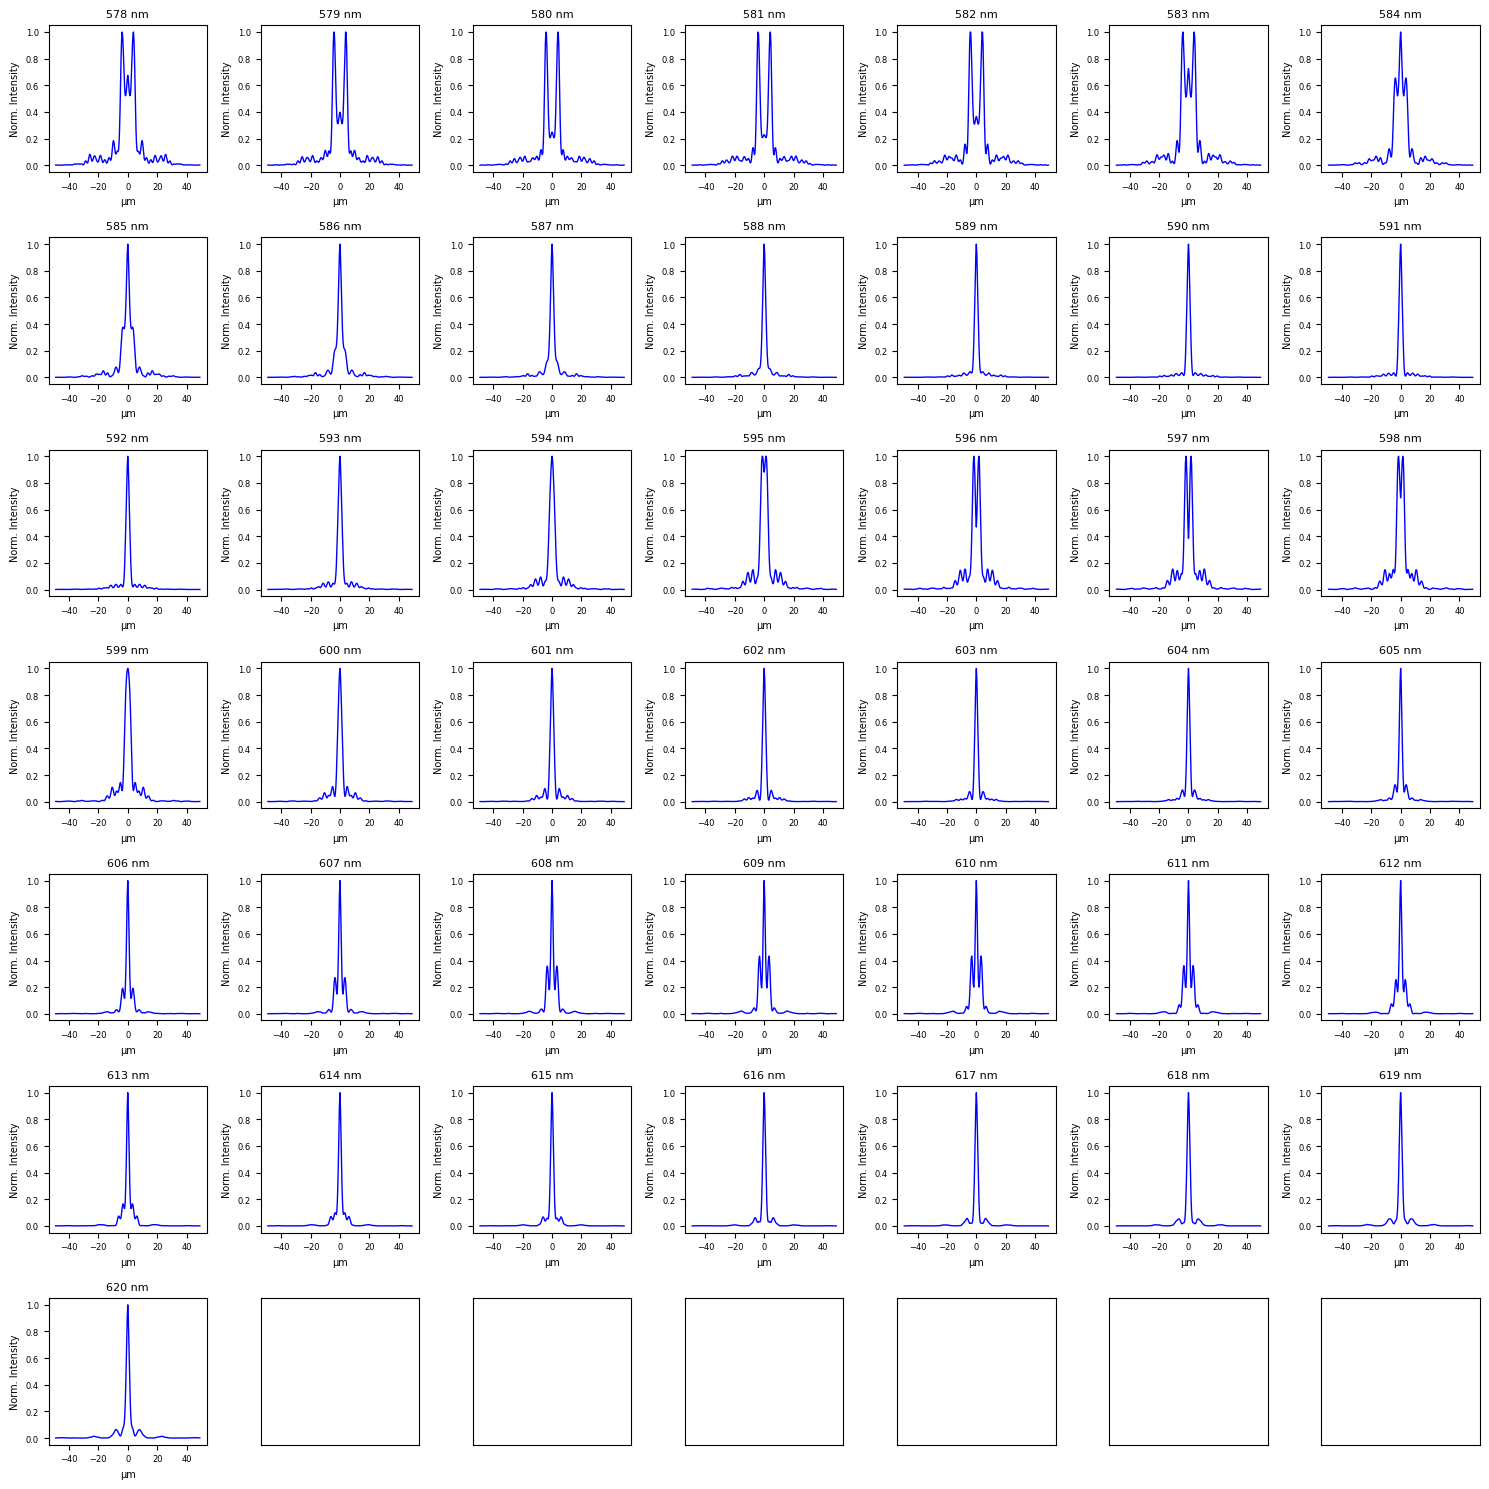

In [6]:
import tqdm
psf_2d_list = list()
psf_1d_list = list()
pitch = get_pitch(param)

x_all = 2.0*torch.sigmoid(layer2_indices)-1
y_all = 2.0*torch.sigmoid(layer1_indices)-1
grid = torch.stack([x_all, y_all], dim=2)
grid = grid.reshape(1, -1, param.R, param.C)

crop_half = 100
for wvl in tqdm.tqdm(param.training_wvls):
    complex_field_dict = lut_sampler_hard(keys=[int(wvl*1e+9)], grid=grid, class_logits=class_logits)
    complex_field = complex_field_dict[int(wvl*1e+9)]
    light = pado.Light((1,1,param.R, param.C), pitch=pitch, wvl=wvl, field=complex_field, device=args.device)
    psf = compute_psf(wvl, light, args, 'SBL_ASM', offset=(0, 0), normalize=False, resize=False)

    psf_crop = psf[0,0,psf.shape[-2]//2-crop_half:psf.shape[-2]//2+crop_half, psf.shape[-1]//2-crop_half:psf.shape[-1]//2+crop_half]
    psf_2d_list.append(psf_crop)
    psf_1d_list.append(radial_mean_2d(psf_crop))

plot_psf_2d_grid(psf_2d_list, param.training_wvls, pitch, nrows=7, ncols=7, cmap="magma")
plot_psf_1d_grid(psf_1d_list, param.training_wvls, pitch, nrows=7, ncols=7, x_mode="radial")

# Z-scan

Z-scan wavelengths: [479, 500, 520, 540, 560, 580, 600, 620, 640]


0it [00:00, ?it/s]/workspace/MultiLayerLUTMetalens copy/pado/light.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, device=self.device)[None, None, :, :]
21it [00:00, 67.35it/s]

100it [00:01, 67.30it/s]


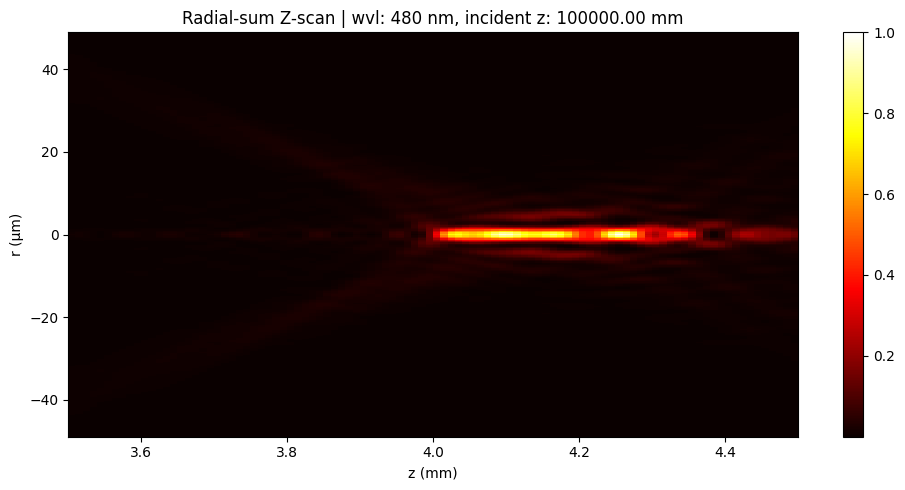

100it [00:01, 67.53it/s]


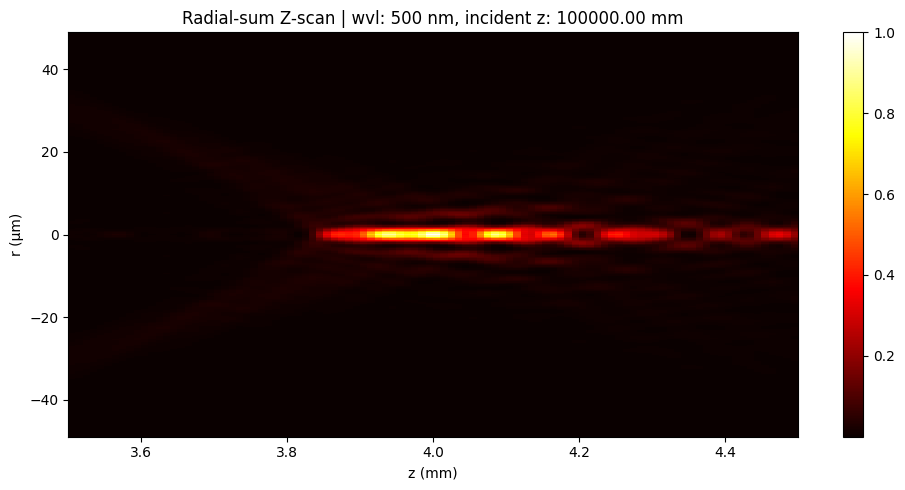

100it [00:01, 67.44it/s]


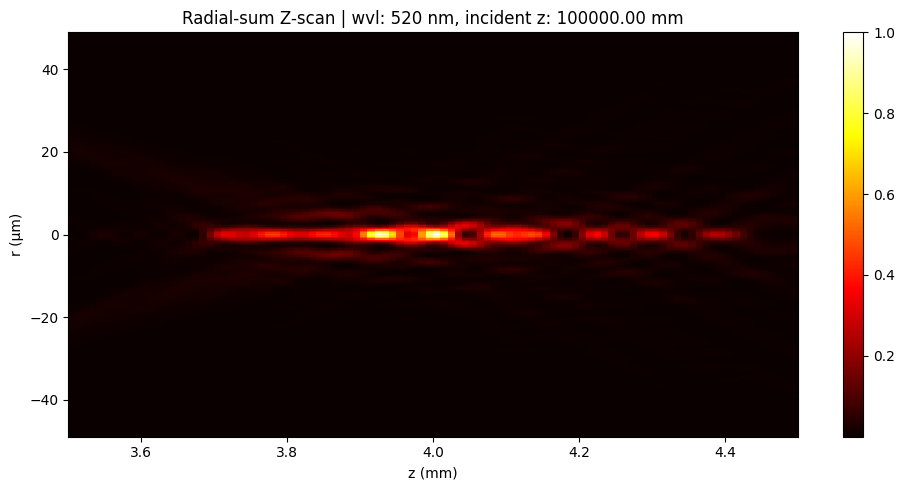

100it [00:01, 67.58it/s]


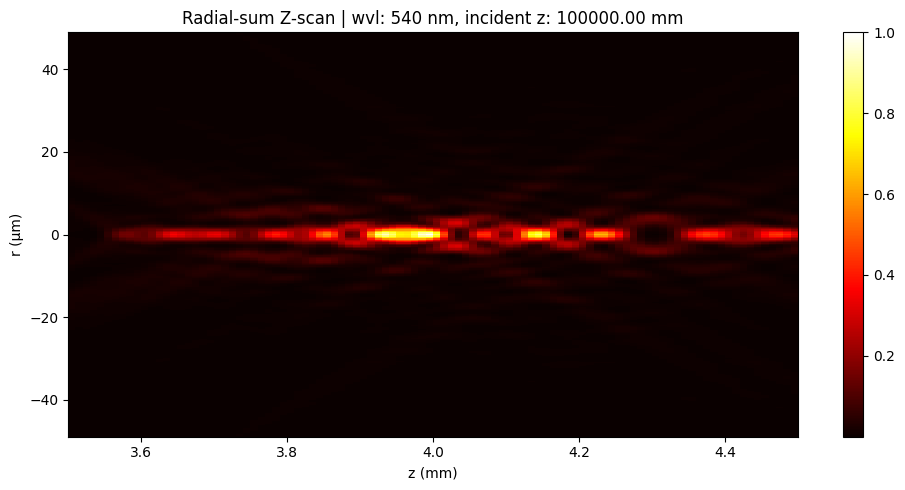

100it [00:01, 67.48it/s]


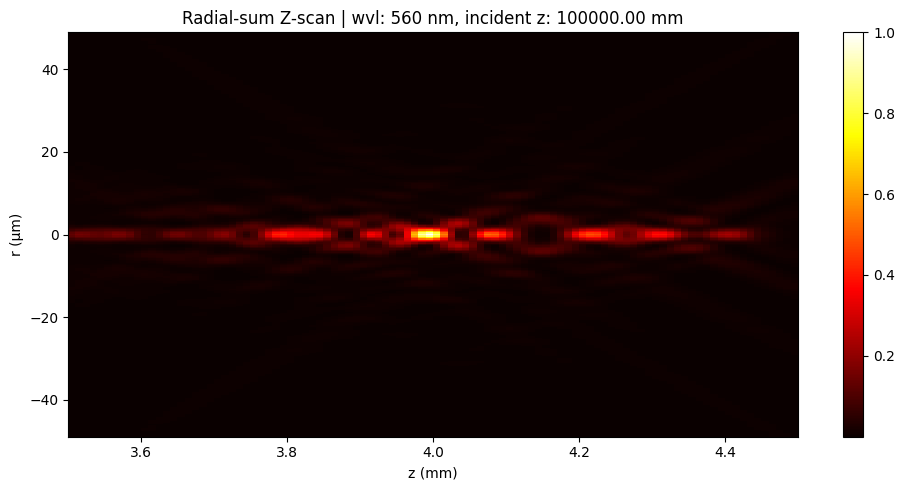

100it [00:01, 67.43it/s]


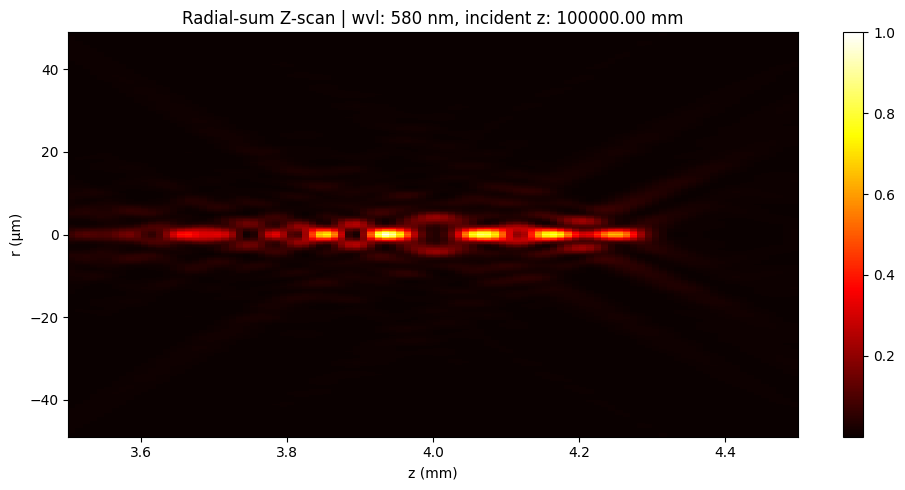

100it [00:01, 67.38it/s]


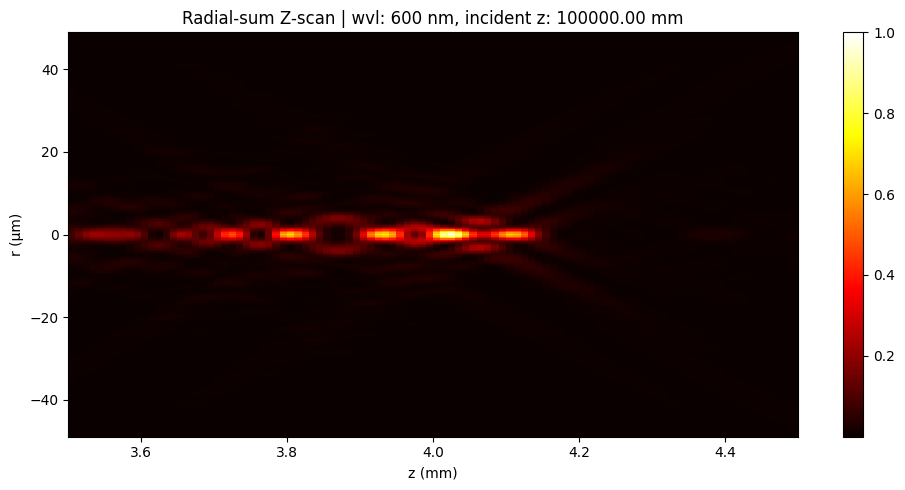

100it [00:01, 67.44it/s]


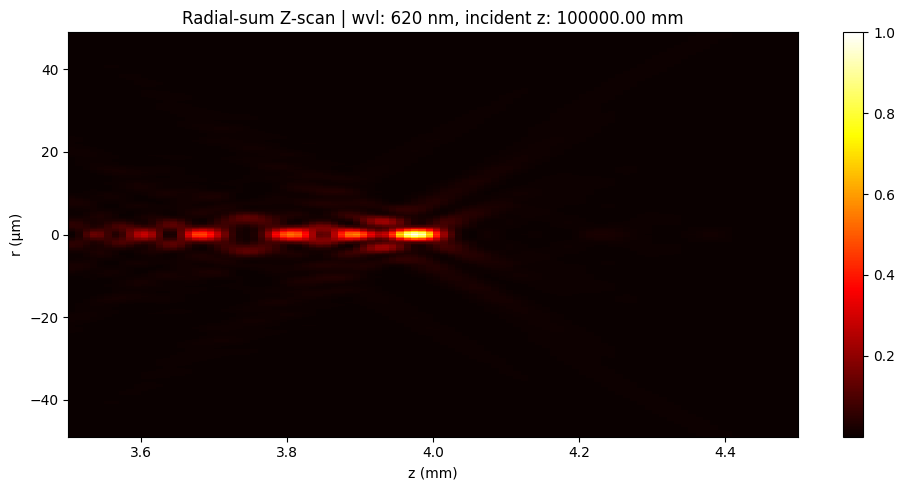

100it [00:01, 67.31it/s]


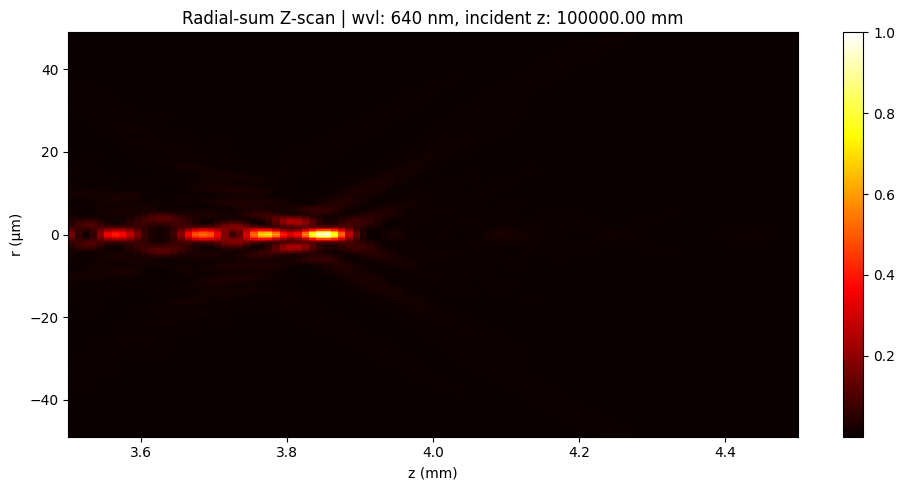

In [7]:
# Z-scan: user-chosen wavelengths
zscan_wvls = [480e-9, 500e-9, 520e-9, 540e-9, 560e-9, 580e-9, 600e-9, 620e-9, 640e-9]
print(f"Z-scan wavelengths: {[int(w*1e9) for w in zscan_wvls]}")

pitch = get_pitch(param)
x_all = 2.0*torch.sigmoid(layer2_indices)-1
y_all = 2.0*torch.sigmoid(layer1_indices)-1
grid = torch.stack([x_all, y_all], dim=2)
grid = grid.reshape(1, -1, param.R, param.C)

depths = torch.linspace(param.focal_length-0.5e-3, param.focal_length+0.5e-3, 100)
incident_z = 100

for wvl in zscan_wvls:
    complex_field_dict = lut_sampler_hard(keys=[int(wvl*1e+9)], grid=grid, class_logits=class_logits)
    complex_field = complex_field_dict[int(wvl*1e+9)]
    xz, radial, x_um, r_um, z_mm = compute_psf_zscan(args, complex_field, depths, incident_z, wvl, crop_half=100, normalizer=None)
    # plot_zscan_xz(xz, x_um, z_mm, wvl, incident_z)
    plot_zscan_radial(radial, r_um, z_mm, wvl, incident_z)

# Image formation result

In [8]:
img_GT= torch.tensor(plt.imread('./img_dataset/Natural/sample/0003.png'), device=args.device).permute(2,0,1).unsqueeze(0)

pitch = get_pitch(param)
x_all = 2.0*torch.sigmoid(layer2_indices)-1
y_all = 2.0*torch.sigmoid(layer1_indices)-1
grid = torch.stack([x_all, y_all], dim=2)
grid = grid.reshape(1, -1, param.R, param.C)

for channel_idx, wvl in enumerate(zscan_wvls):
    complex_field_dict = lut_sampler_hard(keys=[int(wvl*1e+9)], grid=grid, class_logits=class_logits)
    complex_field = complex_field_dict[int(wvl*1e+9)]
    light = pado.Light((1,1,param.R, param.C), pitch=pitch, wvl=wvl, field=complex_field, device=args.device)
    psf = compute_psf(wvl, light, args, 'SBL_ASM', offset=(0, 0), normalize=False)

    img_convolved[:,channel_idx,...] = fft_convolve2d_image_reflection(img_GT[:,channel_idx:channel_idx+1,...], (psf)/(psf).sum())

visualize(img_GT, title='img_GT', axis=False)
visualize(img_convolved, title='img_convolved', axis=False)


NameError: name 'img_convolved' is not defined